In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout

In [2]:
exchange_data = pd.read_csv('USD_VND Historical Data.csv')
#exchange_data = pd.read_csv('USD_EUR Historical Data.csv')
#exchange_data = pd.read_csv('USD_RUB Historical Data.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/29/2023,24260.0,24270.0,24300.0,24240.0,NaN,0.10%
1,12/28/2023,24235.0,24300.0,24355.0,24250.0,NaN,-0.45%
2,12/27/2023,24345.0,24375.0,24391.0,24315.0,NaN,0.08%
3,12/26/2023,24325.0,24250.0,24335.0,24210.0,NaN,0.39%
4,12/25/2023,24230.0,24220.0,24265.0,24180.0,NaN,-0.02%


In [3]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [4]:
#checking dataset
ind_exchange_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-12-29,24260.0,24270.0,24300.0,24240.0,NaN,0.10%
2023-12-28,24235.0,24300.0,24355.0,24250.0,NaN,-0.45%
2023-12-27,24345.0,24375.0,24391.0,24315.0,NaN,0.08%
2023-12-26,24325.0,24250.0,24335.0,24210.0,NaN,0.39%
2023-12-25,24230.0,24220.0,24265.0,24180.0,NaN,-0.02%


In [5]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Change %,High,Low,Open,Price,Vol.
Date,,,,,,
2010-01-01,0.00%,18474.0,18469.0,18469.0,18474.0,NaN
2010-01-04,0.00%,18479.0,18450.0,18469.0,18474.0,NaN
2010-01-05,0.00%,18482.0,18450.0,18474.0,18474.0,NaN
2010-01-06,0.00%,18482.0,18469.0,18469.0,18474.0,NaN
2010-01-07,0.01%,18477.5,18450.0,18469.0,18476.5,NaN


<Axes: xlabel='Date'>

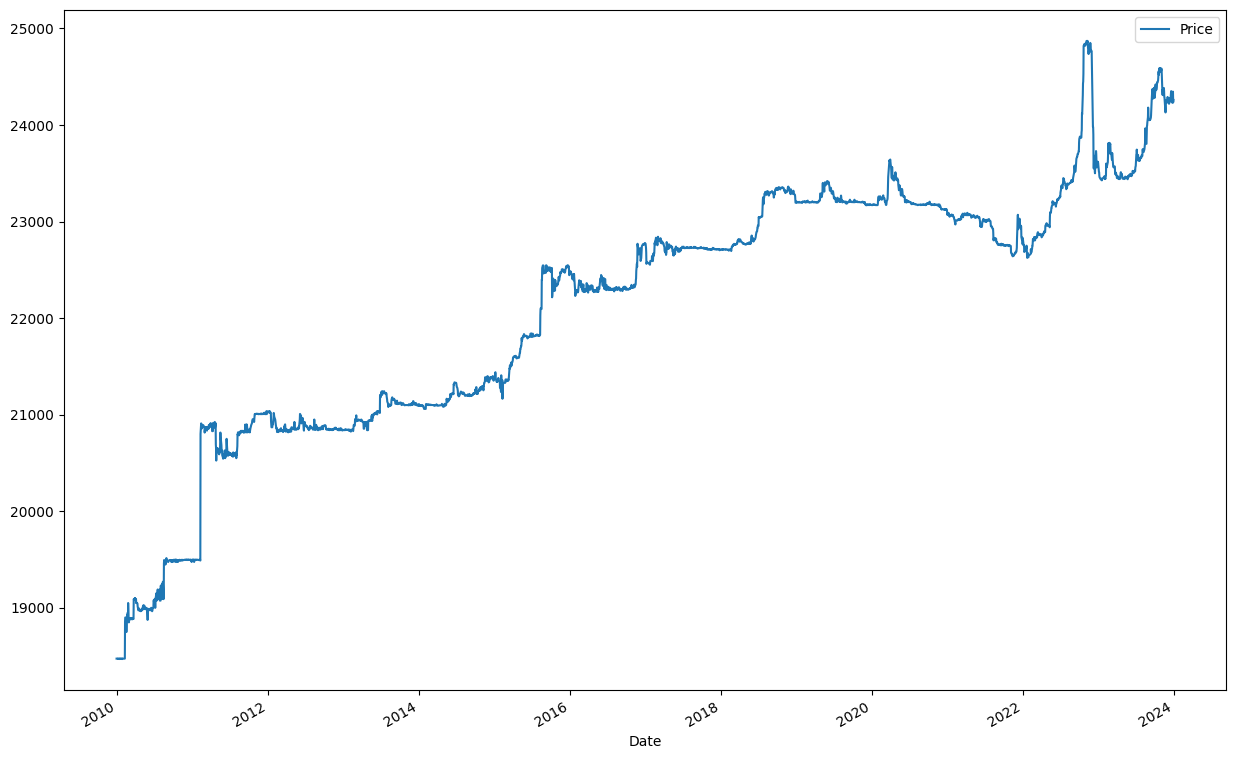

In [6]:
df = data_frame[["Price"]]
#visualize prices over the years
df.plot(kind='line',figsize=(15,10))

 dataset in terms of years and further check 100% of the dataset lies within which interval

In [7]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("100 percent data = 2010 to %d"%(2010 + int(1*years)))

Total data: 14 years
100 percent data = 2010 to 2024


In [8]:
# Summary Statistics
df.describe()

,Price
count,3615.000000
mean,22100.362628
std,1333.720867
min,18469.500000
25%,21035.500000
50%,22572.000000
75%,23177.500000
max,24871.000000


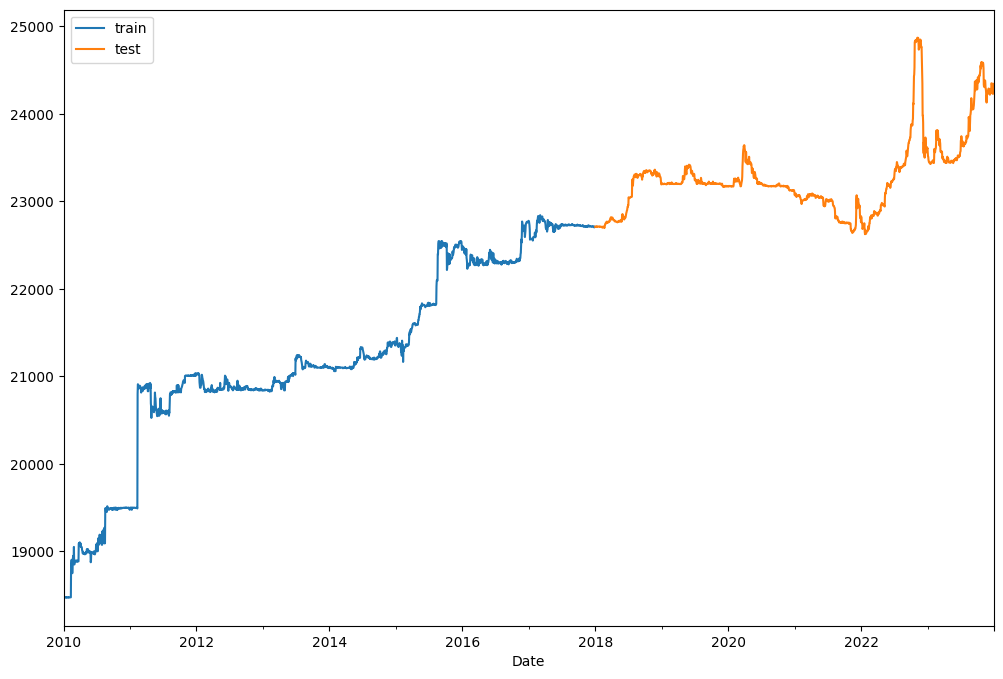

In [9]:
# Train Test Split
split_date = pd.Timestamp('01-01-2018')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

### Data Normalization

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
X_train

array([[-2.54333621],
       [-2.54333621],
       [-2.54333621],
       ...,
       [ 1.35400075],
       [ 1.35400075],
       [ 1.35354078]])

### ANN

In [14]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0372 - rmse: 1.3530  
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6607 - rmse: 1.2186
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3555 - rmse: 1.0988
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0855 - rmse: 0.9815
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.8478 - rmse: 0.8654
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.6425 - rmse: 0.7514
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4728 - rmse: 0.6429  
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.3412 - rmse: 0.5445
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2380 - rmse: 0.4533
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1603 - rmse: 0.3712
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1055 - rmse: 0.3011
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0694 - rmse: 0.2453
Epoch 13/100
66

KeyboardInterrupt: 

In [ ]:
model.save('ann.h5')
#print("Saving the model as ann.h5")

#model.save('ann_EUR.h5')
#print("Saving the model as ann_EUR.h5")

#model.save('ann_RUB.h5')
#print("Saving the model as ann_RUB.h5")

### ANN Prediction

In [ ]:
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

def adj_r2_score(r2, n, k):
  return 1-((1-r2)*((n-1)/(n-k-1)))

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
The R2 score on the Train set is:	0.998
The  MAE on the Train set is:	0.021
The  RMSE on the Train set is:	0.042
The Adjusted R2 score on the Train set is:	0.998

The R2 score on the Test set is:	0.985
The Adjusted R2 score on the Test set is:	0.985
The  MAE on the Test set is:	0.033
The  RMSE on the Test set is:	0.049


### ANN Prediction Plot

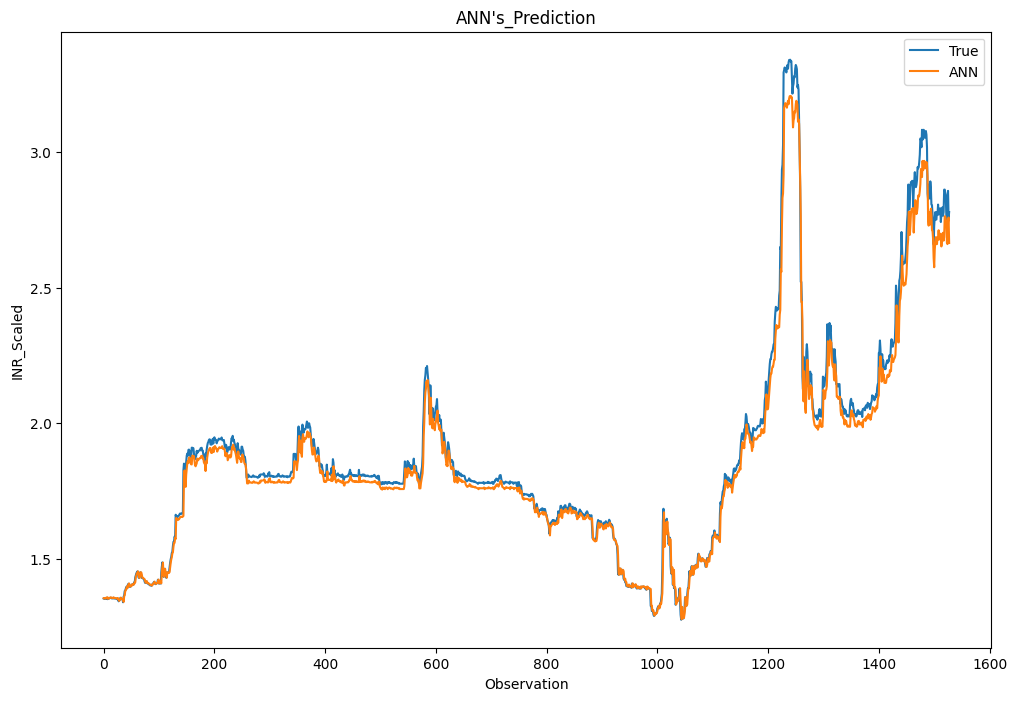

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained GRU model
model = load_model('ann.h5')
#model = load_model('ann_EUR.h5')
#model = load_model('ann_RUB.h5')

# Define input features and preprocessing
def preprocess_input(input_data):
    # Perform any necessary preprocessing here (e.g., scaling)
    # For simplicity, we'll just return the input as is
    input_data = sc.transform(input_data)
    return input_data

# Function to get user input
def get_user_input():
    # Collect input features from the user
    usd_to_money = float(input("Enter USD for exchange rate: "))

    # Add more features as needed
    return usd_to_money

# Make predictions
def predict_exchange_rate(model, input_features):
    # Reshape input features to match model input shape
    input_features = np.array(input_features).reshape(1, len(input_features))
    # Preprocess input
    preprocessed_input = preprocess_input(input_features)
    # Make prediction
    predicted_exchange_rate = model.predict(preprocessed_input)
    predicted_exchange_rate = sc.inverse_transform(predicted_exchange_rate)
    return predicted_exchange_rate

# Display results
def display_results(prediction):
    print("Predicted exchange rate:", prediction)

# Main function
def main():
    # Get user input
    usd_to_money = get_user_input()

    # Combine input features
    input_features = [usd_to_money]

    # Make predictions
    predicted_exchange_rate = predict_exchange_rate(model, input_features)

    # Display results
    display_results(predicted_exchange_rate)

if __name__ == "__main__":
    main()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted exchange rate: [[12865.682]]


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
